In [1]:
# adapted from https://www.tensorflow.org/tutorials/generative/autoencoder

import tensorflow as tf
from tensorflow.keras import losses, datasets, Model
from load_oxford_flowers102 import load_oxford_flowers102
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Flatten, Concatenate

# Load Oxford Flowers dataset
train_data, validation_data, test_data, class_names = load_oxford_flowers102(imsize=96, fine=False)

y_hat_train = train_data["labels"]
y_hat_test = test_data["labels"]
x_train = train_data["images"]
x_test = test_data["images"]
x_valid = validation_data["images"]
y_hat_valid = validation_data["labels"]

# Normalize pixel values to [0, 1]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Reshape data to include channel dimension
# x_train = tf.expand_dims(x_train, axis=-1)
# x_test = tf.expand_dims(x_test, axis=-1)

# Print dataset shapes
print(x_train.shape)
print(x_test.shape)


2024-04-10 14:23:15.857735: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-10 14:23:15.880399: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-10 14:23:16.301199: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqd

(1788, 96, 96, 3)
(320, 96, 96, 3)


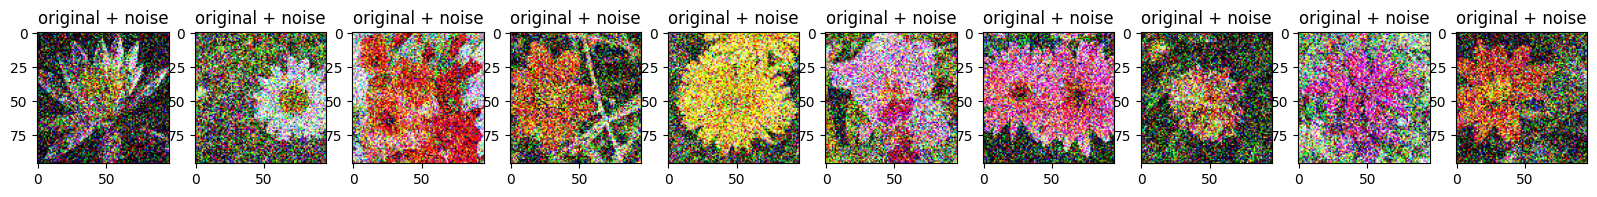

In [36]:
noise_factor = 0.4
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
plt.show()

In [37]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      Input(shape=(96, 96, 3)),
      Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())


In [2]:
# adapted from https://medium.com/geekculture/u-net-implementation-from-scratch-using-tensorflow-b4342266e406


def encode_block(inputs, n_filters):
    conv = Conv2D(n_filters, kernel_size=(3,3), activation='relu', padding='same')(inputs)
    conv = Conv2D(n_filters, kernel_size=(3,3), activation='relu', padding='same')(conv)
    out = MaxPooling2D(strides=(2,2))(conv)
    skip = conv
    return out, skip

def decode_block(inputs, skip, n_filters):
    upconv = Conv2DTranspose(n_filters, kernel_size=(3,3), strides=(2,2), padding='same')(inputs)
    concat = Concatenate()([upconv, skip])
    conv = Conv2D(n_filters, kernel_size=(3,3), activation='relu', padding='same')(concat)
    out = Conv2D(n_filters, kernel_size=(3,3), activation='relu', padding='same')(conv)
    return out

def bottleneck(inputs, n_filters):
    conv = Conv2D(n_filters, kernel_size=(3,3), activation='relu', padding='same')(inputs)
    conv = Conv2D(n_filters, kernel_size=(3,3), activation='relu', padding='same')(conv)
    return conv

def create_unet(input_shape):
    inputs = Input(input_shape)

    encode1, skip1 = encode_block(inputs, n_filters=64)
    encode2, skip2 = encode_block(encode1, n_filters=128)
    encode3, skip3 = encode_block(encode2, n_filters=256)
    encode4, skip4 = encode_block(encode3, n_filters=512)

    latent_dim = bottleneck(encode4, n_filters=1024)

    decode1 = decode_block(latent_dim, skip4, n_filters=512)
    decode2 = decode_block(decode1, skip3, n_filters=256)
    decode3 = decode_block(decode2, skip2, n_filters=128)
    decode4 = decode_block(decode3, skip1, n_filters=64)

    out = Conv2D(3, kernel_size=(1,1), padding='same')(decode4)

    model = tf.keras.Model(inputs=inputs, outputs=out)
    # model.summary()
    return model        

unet = create_unet(x_train[0].shape)
unet.summary()



2024-04-10 14:23:22.387920: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-10 14:23:22.406112: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-10 14:23:22.406206: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 96, 96,    │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 96, 96,    │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 48, 48,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 48, 48,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 48, 48,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 24, 24,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 24, 24,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 24, 24,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 12, 12,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 12, 12,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 12, 12,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 6, 6, 512) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 6, 6,      │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 6, 6,      │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 12, 12,    │  4,719,104 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 12, 12,    │          0 │ conv2d_transpose

 Total params: 34,513,475 (131.66 MB)

 Trainable params: 34,513,475 (131.66 MB)

 Non-trainable params: 0 (0.00 B)

In [3]:
unet.compile(optimizer=tf.keras.optimizers.Adam(), 
             loss=tf.keras.losses.MeanSquaredError())
unet.fit(x_train, x_train,
         epochs=10,
         shuffle=True,
         validation_data=(x_test, x_test))

Epoch 1/10


I0000 00:00:1712715811.193193   61704 service.cc:145] XLA service 0x7e6510002a90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1712715811.193227   61704 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2024-04-10 14:23:31.251768: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-10 14:23:31.508372: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-04-10 14:23:31.706695: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 160.14MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-10 14:23:31.706739: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] 

UnknownError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 359, in execute_request

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 446, in do_execute

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_52998/2013782733.py", line 3, in <module>

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 325, in fit

  File "/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 118, in one_step_on_iterator

Failed to determine best cudnn convolution algorithm for:
%cudnn-conv-bw-input.30 = (f32[32,128,96,96]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,96,96]{3,2,1,0} %select.40, f32[64,128,3,3]{3,2,1,0} %transpose.394), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", metadata={op_type="Conv2DBackpropInput" op_name="gradient_tape/functional_1_1/conv2d_16_1/convolution/Conv2DBackpropInput" source_file="/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1177}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}}

Original error: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 167772160 bytes.

To ignore this failure and try to use a fallback algorithm (which may have suboptimal performance), use XLA_FLAGS=--xla_gpu_strict_conv_algorithm_picker=false.  Please also file a bug for the root cause of failing autotuning.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_iterator_7559]

In [38]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0927 - val_loss: 0.0692
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0499 - val_loss: 0.0257
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0241 - val_loss: 0.0213
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0204 - val_loss: 0.0195
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0195 - val_loss: 0.0183
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0183 - val_loss: 0.0176
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0175 - val_loss: 0.0169
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0173 - val_loss: 0.0165
Epoch 9/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0166 - val_loss: 0.0161
Epoch 10/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0163 - val_loss: 0.0159


In [39]:
autoencoder.encoder.summary()
autoencoder.decoder.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 48, 48, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 8)      │         1,160 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,608 (6.28 KB)

 Trainable params: 1,608 (6.28 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_transpose_2              │ (None, 48, 48, 8)      │           584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 96, 96, 16)     │         1,168 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 96, 96, 3)      │           435 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,187 (8.54 KB)

 Trainable params: 2,187 (8.54 KB)

 Non-trainable params: 0 (0.00 B)

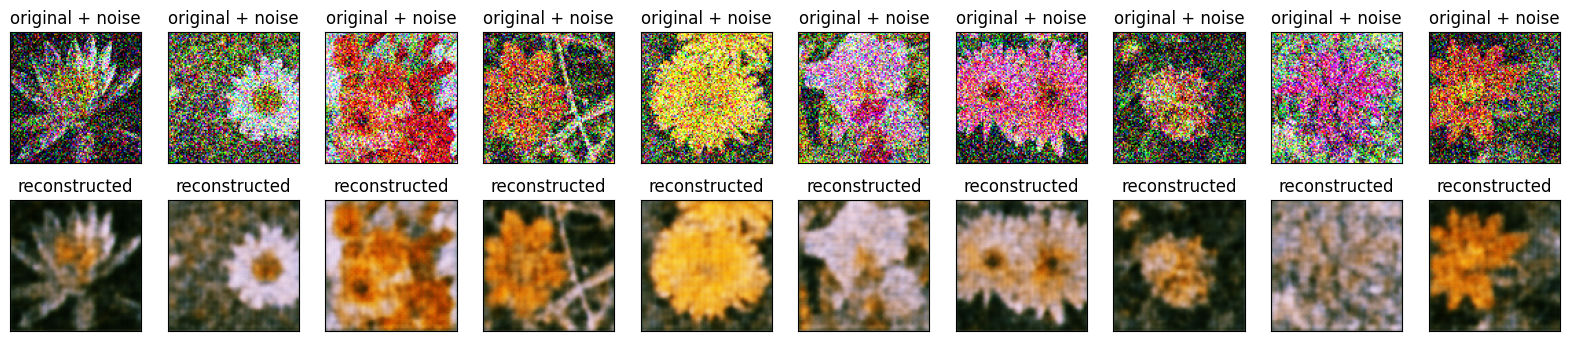

In [40]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

In [ ]:
decoded_imgs=unet.predict(x_train[:10])
original_imgs = x_train[:10]

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(original_imgs[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

In [41]:
noise_images = tf.random.normal((10, 24, 24, 8))

noise_images = tf.clip_by_value(noise_images, clip_value_min=0., clip_value_max=1.)

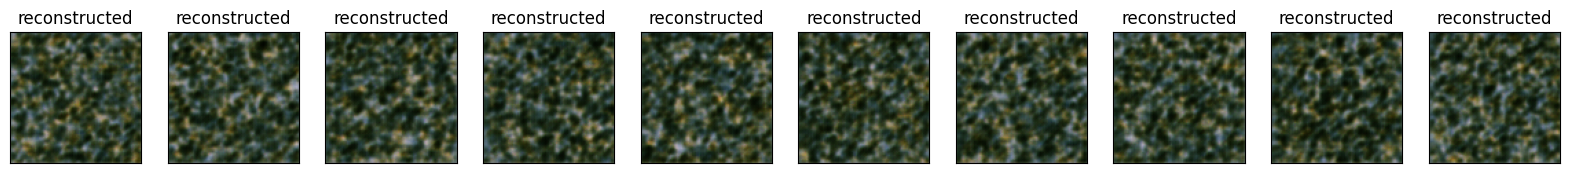

In [42]:
decoded_imgs = autoencoder.decoder(noise_images).numpy()

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

# Create data set of noise to less noise

In [56]:
x_train_noise = []
y_train_noise = []

for image in x_train:
    for noise_factor in np.arange(0.0, 1.0, 0.1):
        x = image + (noise_factor + 0.1) * tf.random.normal(shape=image.shape) 
        y = image + noise_factor * tf.random.normal(shape=image.shape) 

        x = tf.clip_by_value(x, clip_value_min=0., clip_value_max=1.)
        y = tf.clip_by_value(y, clip_value_min=0., clip_value_max=1.)

        x_train_noise.append(x)
        y_train_noise.append(y)

x_train_noise = np.array(x_train_noise)
y_train_noise = np.array(y_train_noise)

In [57]:
x_test_noise = []
y_test_noise = []

for image in x_test:
    for noise_factor in np.arange(0.0, 1.0, 0.1):
        x = image + (noise_factor + 0.1) * tf.random.normal(shape=image.shape) 
        y = image + noise_factor * tf.random.normal(shape=image.shape) 

        x = tf.clip_by_value(x, clip_value_min=0., clip_value_max=1.)
        y = tf.clip_by_value(y, clip_value_min=0., clip_value_max=1.)

        x_test_noise.append(x)
        y_test_noise.append(y)

x_test_noise = np.array(x_test_noise)
y_test_noise = np.array(y_test_noise)

In [63]:
x_test_noise.shape

(3200, 96, 96, 3)

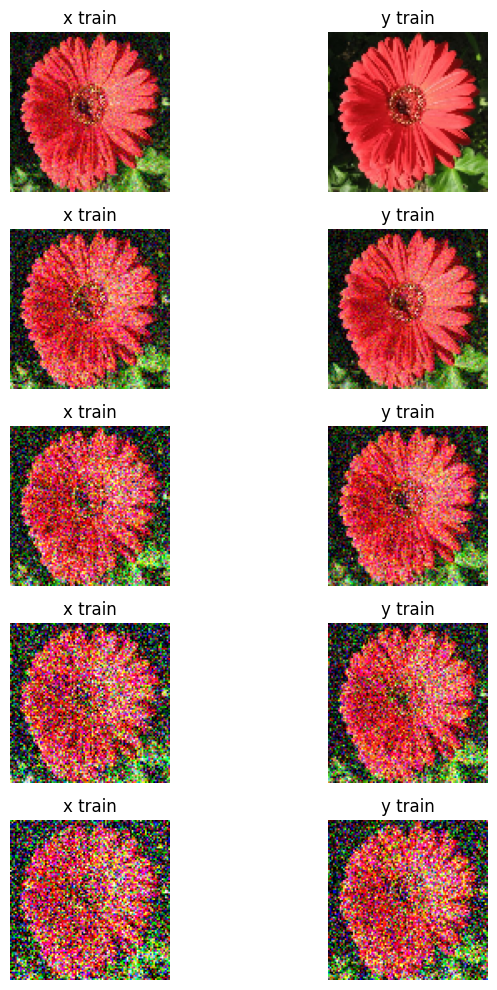

In [52]:
fig, axes = plt.subplots(5, 2, figsize=(8, 10))
for i, ax in enumerate(axes):
    ax[0].imshow(x_train_noise[i])
    ax[0].axis('off')
    ax[0].set_title('x train')
    
    ax[1].imshow(y_train_noise[i])
    ax[1].axis('off')
    ax[1].set_title('y train')

plt.tight_layout()
plt.show()

# Re train auto encoder with noisy images   

In [64]:
autoencoder.fit(x_train_noise, y_train_noise,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
559/559 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0975 - val_loss: 0.0182
Epoch 2/10
559/559 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0946 - val_loss: 0.0162
Epoch 3/10
559/559 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0935 - val_loss: 0.0156
Epoch 4/10
559/559 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0929 - val_loss: 0.0156
Epoch 5/10
559/559 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0939 - val_loss: 0.0160
Epoch 6/10
559/559 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0941 - val_loss: 0.0153
Epoch 7/10
559/559 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0937 - val_loss: 0.0152
Epoch 8/10
559/559 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0943 - val_loss: 0.0154
Epoch 9/10
559/559 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0932 - val_loss: 0.0151
Epoch 10/10
559/559 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0940 - val_loss: 0.0151


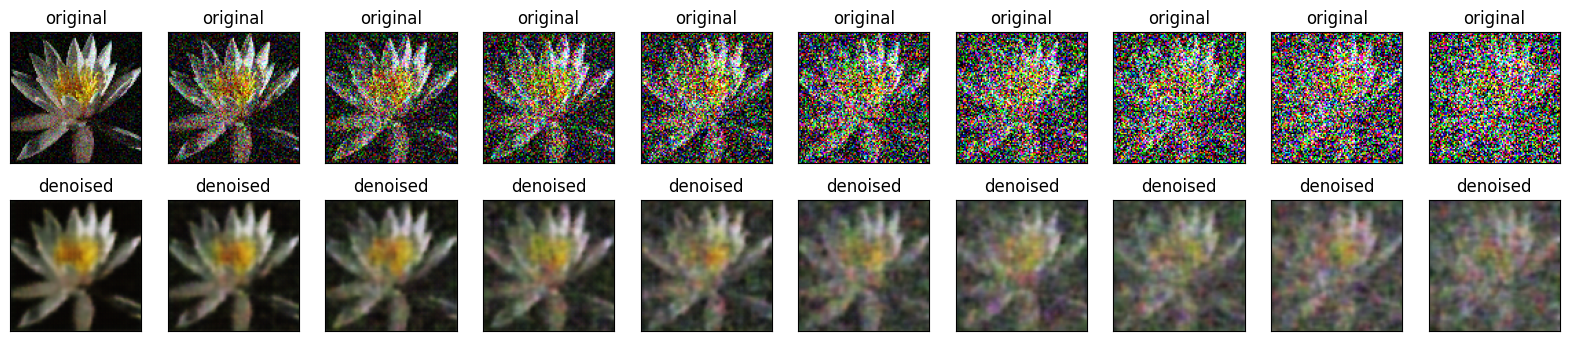

In [70]:
encoded_imgs = autoencoder.encoder(x_test_noise).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original")
    plt.imshow(tf.squeeze(x_test_noise[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("denoised")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

# Generate images from random noise

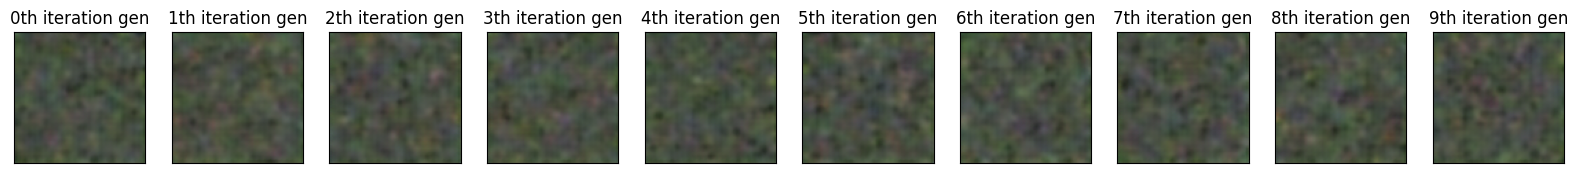

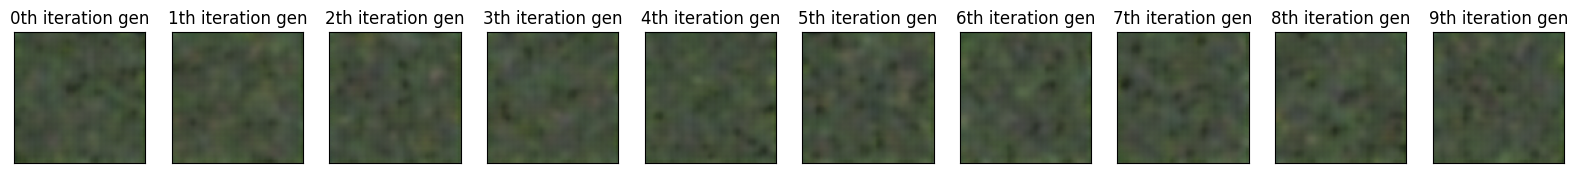

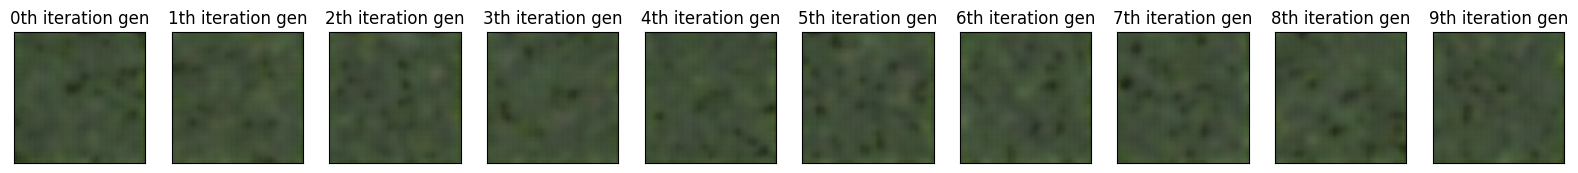

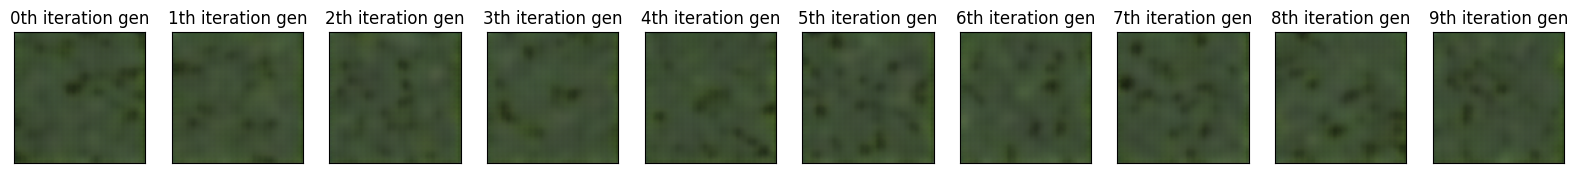

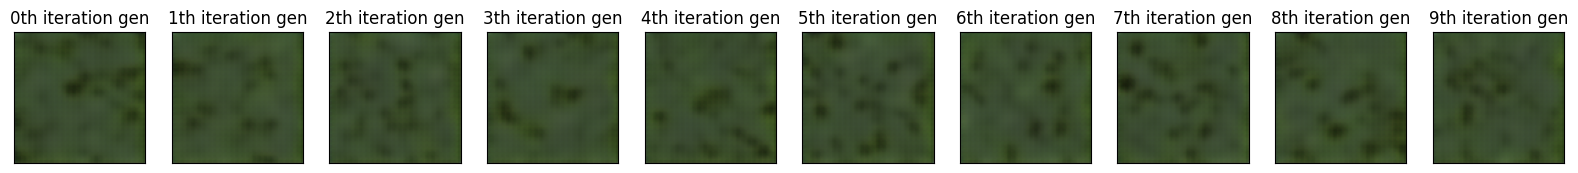

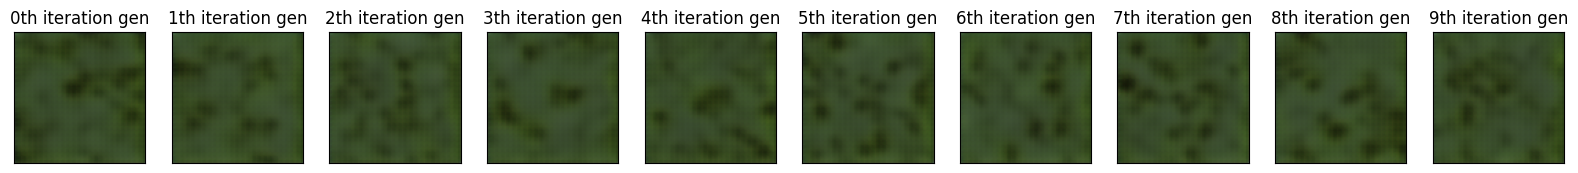

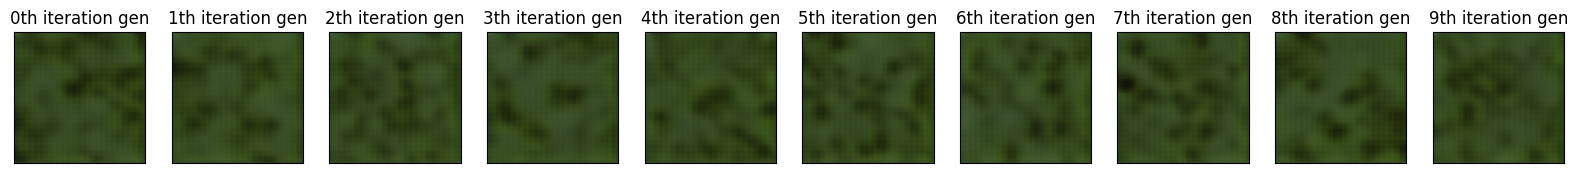

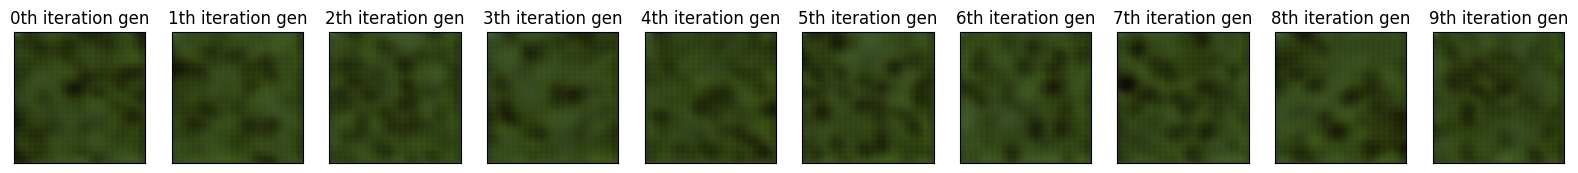

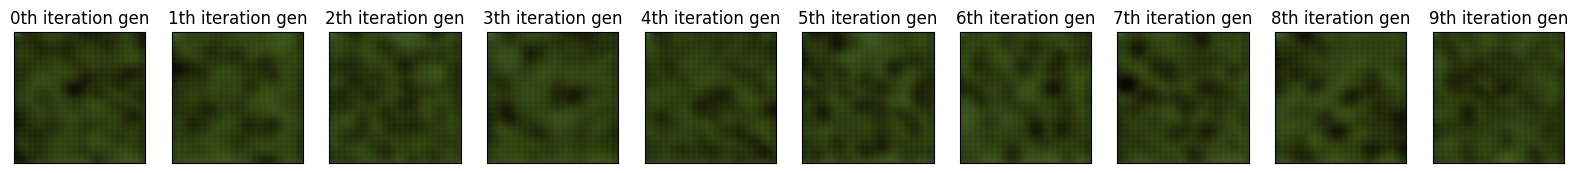

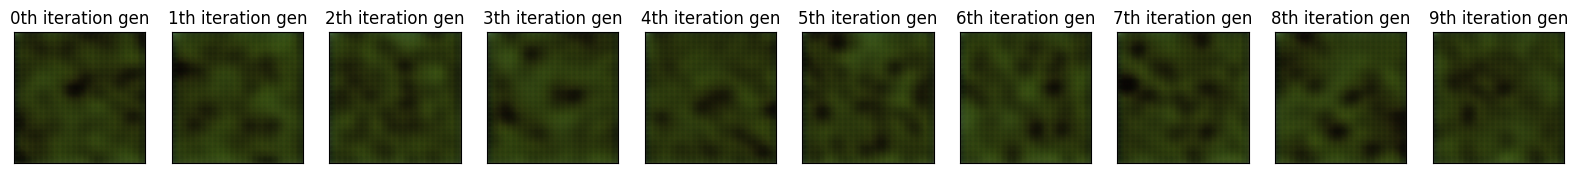

In [98]:
noise_images = tf.random.normal((10, 96, 96, 3))

noise_images = tf.clip_by_value(noise_images, clip_value_min=0., clip_value_max=1.)
encoded_imgs = autoencoder.encoder(noise_images).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

for i in range(10):
    encoded_imgs = autoencoder.encoder(decoded_imgs).numpy()
    decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()


    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):

        # display reconstruction
        bx = plt.subplot(2, n, i + n + 1)
        plt.title(f'{i}th iteration gen')
        plt.imshow(tf.squeeze(decoded_imgs[i]))
        bx.get_xaxis().set_visible(False)
        bx.get_yaxis().set_visible(False)
    plt.show()

In [ ]:
encoded_imgs = autoencoder.encoder(x_test_noise).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

for i in range(10):
    encoded_imgs = autoencoder.encoder(decoded_imgs).numpy()
    decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()


    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):

        # display reconstruction
        bx = plt.subplot(2, n, i + n + 1)
        plt.title(f'{i}th iteration gen')
        plt.imshow(tf.squeeze(decoded_imgs[i]))
        bx.get_xaxis().set_visible(False)
        bx.get_yaxis().set_visible(False)
    plt.show()

In [ ]:
encoded_img = autoencoder.encoder(x_test_noise[8:9]).numpy()  # Pass only the first image
decoded_img = autoencoder.decoder(encoded_img).numpy()

for _ in range(10):
    prev_image = decoded_img
    encoded_img = autoencoder.encoder(decoded_img).numpy()
    decoded_img = autoencoder.decoder(encoded_img).numpy()

    plt.figure(figsize=(3, 3))
    plt.imshow(tf.squeeze(prev_image))  # Show the original noisy image
    plt.axis('off')

    plt.imshow(tf.squeeze(decoded_img))  # Show the reconstructed image after 10 iterations
    plt.axis('off')

    plt.show()


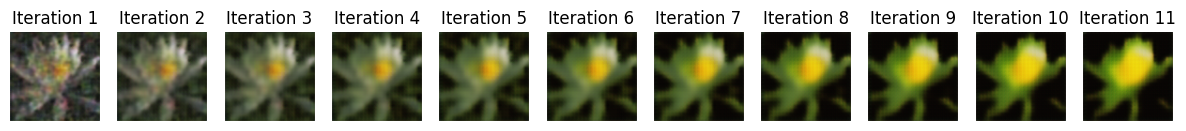

In [120]:
encoded_img = autoencoder.encoder(x_test_noise[4:5]).numpy()  # Pass only the first image
decoded_imgs = [autoencoder.decoder(encoded_img).numpy()]

for _ in range(10):
    encoded_img = autoencoder.encoder(decoded_imgs[-1]).numpy()
    decoded_imgs.append(autoencoder.decoder(encoded_img).numpy())


# Plot all the progressively denoised images together
plt.figure(figsize=(15, 3))
for i in range(len(decoded_imgs)):
    plt.subplot(1, len(decoded_imgs), i + 1)
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.title(f'Iteration {i+1}')
    plt.axis('off')

plt.show()


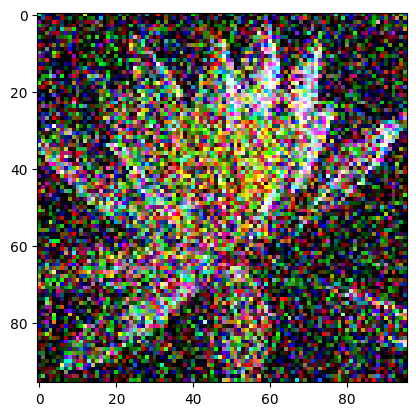

In [122]:
plt.figure()
plt.imshow(x_test_noise[3])
plt.show()